<a id='tutorial'></a>
# Finding Hidden States

> **Note**
> 
> Download the example file here: [HP3_TE300_SPC630.hdf5](https://zenodo.org/record/5902313/files/HP3_TE300_SPC630.hdf5)

To start the analysis of burst data with H<sup>2</sup>MM, we first need to process the data with FRETBursts, one of the dependencies of burstH2MM.

First let's import the necessary modules:

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import fretbursts as frb
import burstH2MM as bhm

sns = frb.init_notebook()

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.7.1).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


and load the data and search for bursts:

In [2]:
filename = 'HP3_TE300_SPC630.hdf5'
# load the data into the data object frbdata
frbdata = frb.loader.photon_hdf5(filename)

Now it is best to check the alternation period etc.:

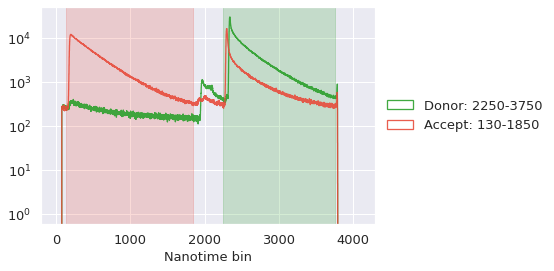

In [3]:
# plot the alternation histogram
frb.bpl.plot_alternation_hist(frbdata)

If the alternation period looks good, we can apply the alternation period to assign Donor/Acceptor excitation to each photon:

In [4]:
# if the alternation period is correct, apply data
frb.loader.alex_apply_period(frbdata)

# Total photons (after ALEX selection):    11,414,157
#  D  photons in D+A excitation periods:    5,208,392
#  A  photons in D+A excitation periods:    6,205,765
# D+A photons in  D  excitation period:     6,611,308
# D+A photons in  A  excitation period:     4,802,849



Then calculate the background rates used to set thresholds for finding bursts:

 - Calculating BG rates ... get bg th arrays
Channel 0
[DONE]


<AxesSubplot:title={'center':'HP3_TE300_SPC630'}, xlabel='Inter-photon delays (ms)', ylabel='# Delays'>

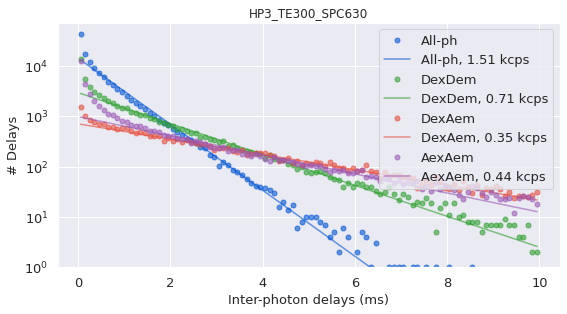

In [5]:
# calcualte the background rate
frbdata.calc_bg(frb.bg.exp_fit, F_bg=1.7)
# plot bg parameters, to verify quality
frb.dplot(frbdata, frb.hist_bg)

And finally search for bursts and refine the selection by appropriate burst size/width/other parameters:

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]
<class 'matplotlib.figure.Figure'>


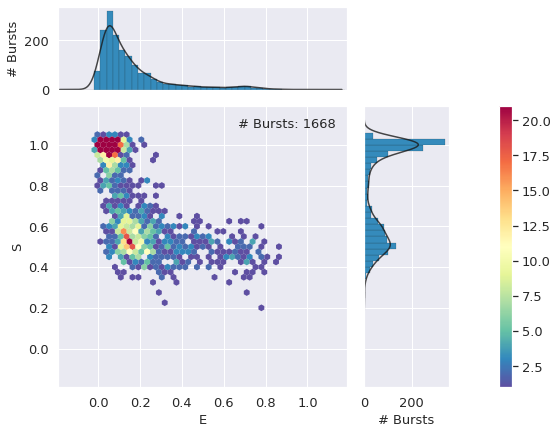

In [6]:
# now perform burst search
frbdata.burst_search(m=10, F=6)
# make sure to set the appropriate thresholds of ALL size
# parameters to the particulars of your experiment
frbdata_sel = frbdata.select_bursts(frb.select_bursts.size, th1=50)

frb.alex_jointplot(frbdata_sel);

## H<sup>2</sup>MM analysis

Now that the data is selected, we can segment the photons into bursts, which will be stored in a BurstData object:

In [7]:
bdata = bhm.BurstData(frbdata_sel)

`bdata` is now the object that will organize the downstream information for optimization. When `bdata` was created, it automatically also generated a [H2MM_list](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_list) object, stored in [BurstData.models](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.BurstData.models) which is where we can perform the H2MM optimizations.

<a id='tutopts'></a>
So let’s run a round of optimizations:

In [8]:
# calculate models
bdata.models.calc_models()

The model converged after 1 iterations

The model converged after 36 iterations

The model converged after 124 iterations

The model converged after 414 iterations

2

### Choosing best model

When you run this, it will optimize H<sup>2</sup>MM models over a range of states. 
The next task is to select the ideal number of states. 
To select this, there are several options, but for now we will use the Integrated Complete Likelihood (ICL). 
The model with the minimal ICL is usually the best model:

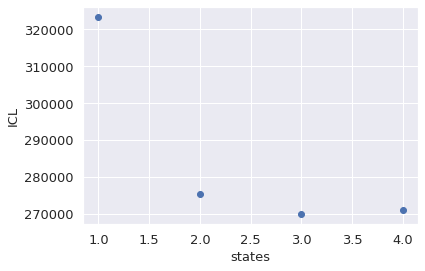

In [9]:
bhm.ICL_plot(bdata.models);

### Inspecting results

Now that the ideal model has been identified, we can plot the E/S values of each dwell with [dwell_ES_scatter()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.Plotting.dwell_ES_scatter), with dwells colored by state.
We can also overlay the E/S values derived from the `H2MM result` over the dwell values with the [scatter_ES()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.Plotting.scatter_ES) function, and add in arrows connecting the states with [trans_arrow_ES()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.Plotting.trans_arrow_ES) function. 

> Note that we pass the `s=75, c='r', ec='k'` arguments to the [scatter_ES()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.Plotting.scatter_ES) function, which ensure the size of the points is appropriate, as well as making the color pop

> There are many more plotting functions. You can review these in the [Plotting](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#plotting) module.

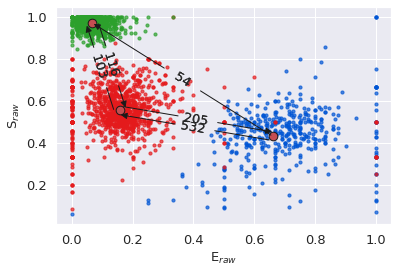

In [10]:
# plot the dwell ES of the result
bhm.dwell_ES_scatter(bdata.models[2])
# overlay with the main values,
bhm.scatter_ES(bdata.models[2], s=75, c="r", ec='k')
# plot arrows and transition rates
bhm.trans_arrow_ES(bdata.models[2]);

We can also view the E and S values of the model with the [H2MM_result.E](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_result.E) and [H2MM_result.S](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_result.S) properties as numpy arrays:

In [11]:
bdata.models[2].E, bdata.models[2].S

(array([0.66031035, 0.15955158, 0.06730048]),
 array([0.43073408, 0.55348988, 0.9708039 ]))

We can also view the transition probability matrix as a numpy array with the [H2MM_result.trans](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_result.trans) property:

In [12]:
bdata.models[2].trans

array([[1.99994147e+07, 5.31727465e+02, 5.35447960e+01],
       [2.05278839e+02, 1.99996914e+07, 1.03279378e+02],
       [7.90898846e+00, 1.16271335e+02, 1.99998758e+07]])

burstH2MM attempts to calculate the most common dwell parameters, and to allow for intelligent selection of different sorts of dwells/bursts and do most of the heavy lifting for the user. These are nearly all stored as attributes in [H2MM_result](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_result) objects.

### Further plotting and customization

This dwell based ES plot from before looked nice, however, the dimensions were a bit odd, usually these types of plots are square.

Matplotlib has the [plt.subplots()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html)  function, which let's use make a figure with a grid of subplots and specify the figure's size.

All plotting functions in burstH2MM have an `ax` keyword argument, which takes a matplotlib axes (`matplotlib.axes._subplots.AxesSubplot`), which specifies the axes where the plot will be drawn, (this is essentially the same as how seaborn and even FRETBursts operate).

Therefore we can easily use [plt.subplots()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) to make a figure and axes, the latter of which to give to our plotting functions:

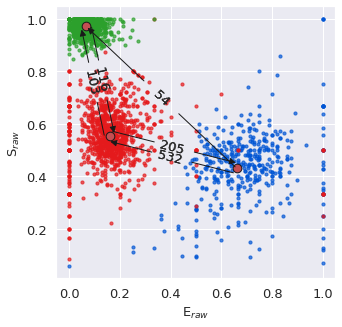

In [13]:
fig, ax = plt.subplots(figsize=(5,5))

# plot the dwell ES of the result
bhm.dwell_ES_scatter(bdata.models[2])
# overlay with the main values,
bhm.scatter_ES(bdata.models[2], s=75, c="r", ec='k')
# plot arrows and transition rates
bhm.trans_arrow_ES(bdata.models[2]);

ES plots are great, but sometimes we like to see 1D histograms.
For that we have the [dwell_E_hist()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.Plotting.dwell_E_hist), [dwell_S_hist](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.Plotting.dwell_S_hist) functions to plot dwell based histograms.
Then we have [axline_E](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.Plotting.axline_E) and [axline_S](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.Plotting.axline_S) to plot vertical or horizontal bars instead of the points we have for the model values.

Since we have two types of histograms to plot, let's take advantage of having multiple subplots in 1 figure and call `plt.subplots(ncols=2, figsize=(12,5))` to make a figure with 2 plots side-by-side (2 columns), with dimensions 12 in x 4 in.

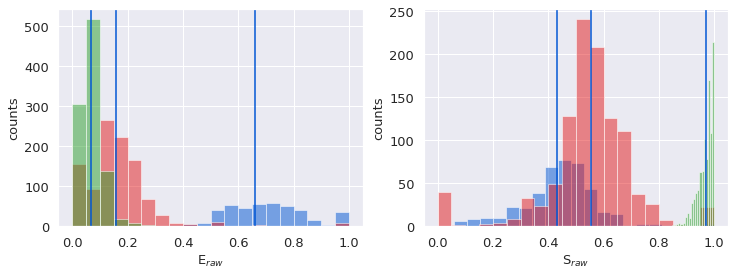

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))

# plot E histogram in 1st subplot
bhm.dwell_E_hist(bdata.models[2], ax=ax[0])
bhm.axline_E(bdata.models[2], ax=ax[0])

# plot S histogram in 2nd subplot
bhm.dwell_S_hist(bdata.models[2], ax=ax[1])
bhm.axline_S(bdata.models[2], ax=ax[1]);

We can even rotate these plots by 90 degrees, using the `orientation='horizontal` and `horizontal=True` keyword arguments for the dwell based histograms and state based lines arguments respectively.

Putting this all together we can make a plot that mimics the `FRETBursts.alex_jointplot()` function:

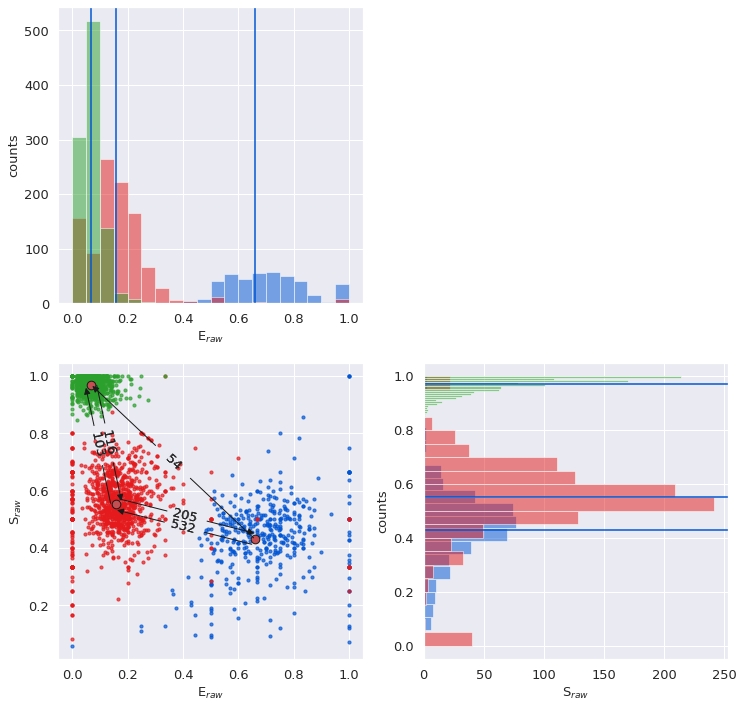

In [15]:
# make plot with 2 rows and 2 columns
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

# plot the dwell ES of the result
bhm.dwell_ES_scatter(bdata.models[2], ax=ax[1,0])
# overlay with the main values,
bhm.scatter_ES(bdata.models[2], s=75, c="r", ec='k', ax=ax[1,0])
# plot arrows and transition rates
bhm.trans_arrow_ES(bdata.models[2], ax=ax[1,0])


# plot E histogram in 1st subplot
bhm.dwell_E_hist(bdata.models[2], ax=ax[0,0]) # ax[0,0] so place in upper left corner
bhm.axline_E(bdata.models[2], ax=ax[0,0])

# plot S histogram in 2nd subplot
bhm.dwell_S_hist(bdata.models[2], ax=ax[1,1], orientation='horizontal') # ax[1,1] so place in upper left corner
bhm.axline_S(bdata.models[2], ax=ax[1,1], horizontal=True);
# silence the unused axis
ax[0,1].axis('off');

## Uncertainty Estimation

Another question is quantifying the error, or uncertainty of the model parameter values.

There are two means to do this:
1. the loglikelihood uncertainty 
2. Bootstrap method

Both wind up being somewhat time consuming, as they require evaluating models.
But the scale differently, the lgolikelihood uncertainty is relatively light per model parameter, but that number grows with the square of the states.
This can be somewhat overcome, as you can just evaluate the uncertainty for the subset of the parameters you are interested in.
On the other hand, the bootstrap method requires several optimizations of subsets of data, so it tends to take longer, but doesn't grow as fast for larger numbers of states.

### Loglikelihood Uncertainty

> **See also**
>
> See the [How-To-Uncertainty-loglik]() for more detailed description of how loglikelihood uncertanty is calculated and accessed.

Loglikelihood uncertainty can be accessed through the [H2MM_result.loglik_err](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_result.loglik_err) attribute, which is a special class, the [ModelError.Loglik_Error](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.ModelError.Loglik_Error) class, which coordinates the calculation and organization of all loglikelihood uncertainty information and calculations.

To calculate a given value, you can use one of the following methods: [ModelError.Loglik_Error.get_E_err()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#Loglik_Error.Loglik_Error.get_E_err), [ModelError.Loglik_Error.get_S_err()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#Loglik_Error.Loglik_Error.get_S_err), and [ModelError.Loglik_Error.get_trans_err()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#Loglik_Error.Loglik_Error.get_trans_err).

[ModelError.Loglik_Error.get_E_err()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#Loglik_Error.Loglik_Error.get_E_err), and [ModelError.Loglik_Error.get_S_err()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#Loglik_Error.Loglik_Error.get_S_err) take a single argument, which is the state for which you want to evaluate the uncertainty.
The return value is the estimated uncertainty.

In [16]:
bdata.models[2].loglik_err.get_E_err(1)

0.001923828124999985

[ModelError.Loglik_Error.get_trans_err()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#Loglik_Error.Loglik_Error.get_trans_err) works a little differently, since the transition rates mark just that: a transition from a state to another state, so instead, this function takes two arguments, the "from state" and "to state" argument.
Transition rates tend to distribute differently, so instead of returning just a single value for the uncertainty, a 2 element array is returend with lower and upper bounds of the estimated error.

In [17]:
bdata.models[2].loglik_err.get_trans_err(0,1)

masked_array(data=[501.85868387495543, 562.357030184412],
             mask=[False, False],
       fill_value=inf)

## Boostrap Uncertainty

The boostrap uncertainty works by subdividing the data into subsets and running optimizations on those subsets, and finally taking the standard deviation of the model parameters across the optimizations of the subsets.

Since this can take some time, before accessing these values, we run the `H2MM_model.bootstrap_eval()` method to calculate the uncertanty.

In [18]:
bdata.models[2].bootstrap_eval()

The model converged after 2153 iterations

The model converged after 418 iterations

The model converged after 194 iterations

The model converged after 232 iterations

The model converged after 205 iterations

The model converged after 270 iterations

The model converged after 319 iterations

The model converged after 416 iterations

The model converged after 287 iterations

The model converged after 225 iterations

(array([[109.28717404, 108.97221846,  70.31538611],
        [ 47.38625393,  64.09983792,  33.98006867],
        [ 16.00797828,  33.65237026,  34.2900651 ]]),
 array([0.03168641, 0.00606686, 0.00233699]),
 array([0.02549997, 0.0118141 , 0.00361265]))

Then we can access the values through the `H2MM_model.E_std_bs`, `H2MM_model.S_std_bs`, and `H2MM_model.trans_std_bs`.

In [19]:
bdata.models[2].E_std_bs, bdata.models[2].S_std_bs

(array([0.03168641, 0.00606686, 0.00233699]),
 array([0.02549997, 0.0118141 , 0.00361265]))

In [20]:
bdata.models[2].trans_std_bs

array([[109.28717404, 108.97221846,  70.31538611],
       [ 47.38625393,  64.09983792,  33.98006867],
       [ 16.00797828,  33.65237026,  34.2900651 ]])

<a id='divisorapproach'></a>
# Divisor Approach

burstH2MM also allows the H2MM input data to incorporate photon nanotimes using the divisor approach. Before using divisors, and therefore nanotimes, it is best to analyze the lifetime decays, and set appropriate thresholds for the IRF of each stream, so we will first plot the decays.

> **Note**
> 
> We are applying these nanotime settings to `bdata`, the original [BurstData](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.BurstData) object created at the beginning of the tutorial. This is because these are universal settings for all [H2MM_list](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_list) objects created from their parent [BurstData](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.BurstData) object. 
> As such, these settings are “remembered” through all children of bdata.

([[<matplotlib.lines.Line2D at 0x7f54c2c63100>],
 <matplotlib.legend.Legend at 0x7f54c2c638e0>)

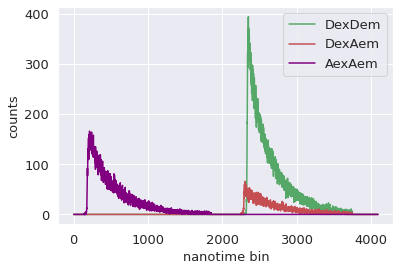

In [21]:
bhm.raw_nanotime_hist(bdata)

Now we can choose the best thresholds for the IRF, and we will set the BurstData.irf_thresh attribute.

> **Note**
> 
> The order of thresholds corresponds to the order of streams in [BurstData.ph_strearms](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.BurstData.ph_strearms) is the order of threshold in [BurstData.irf_thresh](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.BurstData.irf_thresh)

In [22]:
bdata.irf_thresh = np.array([2355, 2305, 220])

Now that the IRF thresholds have been set, we should have no problems down the road when calculating dwell mean nanotimes and other such parameters.

We are now ready to actually start using the divisor approach. First a new divisor must be set:

In [23]:
div_name = bdata.auto_div(1)

This creates a new divisor based [H2MM_list](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_list) object stored in the dictionary [BurstData.div_models](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.BurstData.div_models) with the key returned by the function (stored in `div_name`). So let’s extract the [H2MM_list](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_list) object generated, and then run an optimization:

In [24]:
# run H2MM analysis
bdata.div_models[div_name].calc_models()

The model converged after 2 iterations

The model converged after 28 iterations

The model converged after 82 iterations

The model converged after 394 iterations

2

Next, as before, we need to look at the ICL, to choose the ideal model

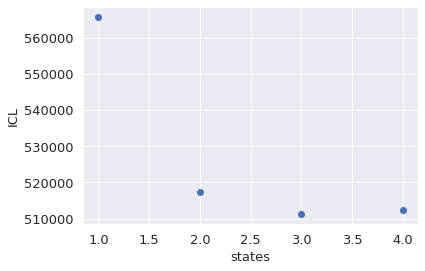

In [25]:
bhm.ICL_plot(bdata.div_models[div_name])

The 3 state model again looks like the best fit, so we will reference it with index 2 (remember python indexes from 0). 
Now we can finally plot the distribution of nanotimes per state. For this there is the [dwell_tau_hist()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.Plotting.dwell_tau_hist)

[[<BarContainer object of 10 artists>],
 [<BarContainer object of 10 artists>],
 [<BarContainer object of 10 artists>]]

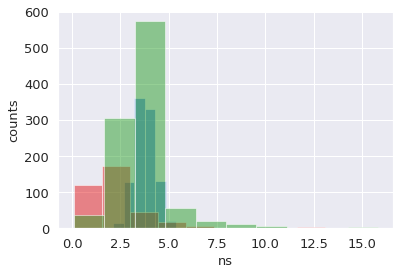

In [26]:
bhm.dwell_tau_hist(bdata.div_models[div_name][2])

And that concludes this tutorial, thank you for your interest in burstH2MM.